In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import os
import glob

In [6]:
#counting the number of respective classes in the respective classes
#       0->glioma
#       1->meningioma
#       2->notumor
#       3->pituitary
ROOT_DIR = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Testing"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# ROOT_DIR = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training"
# for dir in os.listdir(ROOT_DIR):
#   number_of_images[dir] =  number_of_images[dir] + len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [7]:
os.listdir(ROOT_DIR)

['glioma', 'notumor', 'meningioma', 'pituitary']

In [8]:
for i, j in number_of_images.items():
  print(i, ":",j)

glioma : 300
notumor : 405
meningioma : 306
pituitary : 300


# we will split the testing data into :
  * 60% Testing Data
  * 40% Validation Data

In [23]:
# now we will write the code to split the data and place it in a seperate folder
ROOT_DIR = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training"

if not os.path.isdir("/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation"):
  os.mkdir("/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation")
  for dir in os.listdir(ROOT_DIR):
    os.makedirs("/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation/"+dir)
    images_array = np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                size = (math.floor(50/100*number_of_images[dir])),
                                replace = False)
    for img in images_array:
      O = os.path.join(ROOT_DIR, dir, img)
      D = os.path.join("/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation", dir)
      shutil.copy(O, D)
      # os.remove(O)
else:
  print("The folder exists")

In [10]:
os.listdir(ROOT_DIR)

['pituitary', 'meningioma', 'notumor', 'glioma']

# Building the Deep Learning Model

In [12]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [13]:
# Building the CNN model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (224, 224, 3)))

model.add(Conv2D(filters = 36, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 4, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model architecture
model = Sequential()

# Add the convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 output classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [15]:
def preprocessingImageTrain(path):
  """
  input : path
  output : pre processed images
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1/255, horizontal_flip = True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32)

  return image

In [16]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training"
train_data = preprocessingImageTrain(path)

Found 5712 images belonging to 4 classes.


In [17]:
def preprocessingImageTestandValidateAndTest(path):
  """
  input : path
  output : pre processed images
  """
  image_data = ImageDataGenerator(rescale = 1/255)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32)

  return image

In [18]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Testing"
test_data = preprocessingImageTestandValidateAndTest(path)

Found 1311 images belonging to 4 classes.


In [24]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation"
val_data = preprocessingImageTestandValidateAndTest(path)

Found 655 images belonging to 4 classes.


In [25]:
# Early stopping and model checkpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping
es = EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10, verbose = 1, mode = 'auto')

# model checkpoint
mc = ModelCheckpoint(filepath = "bestmodel.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True)
cb = [es, mc]

In [27]:
hist = model.fit_generator(train_data,
                    steps_per_epoch = 8,
                    epochs = 20,
                    validation_data = val_data,
                    validation_steps = 8,
                    callbacks = cb)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.7031
Epoch 1: val_accuracy improved from 0.76172 to 0.81250, saving model to bestmodel.h5
8/8 [==============================] - 8s 1s/step - loss: 0.7321 - accuracy: 0.7031 - val_loss: 0.5195 - val_accuracy: 0.8125
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.6719
Epoch 2: val_accuracy did not improve from 0.81250
8/8 [==============================] - 5s 669ms/step - loss: 0.8226 - accuracy: 0.6719 - val_loss: 0.6682 - val_accuracy: 0.7266
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.6836
Epoch 3: val_accuracy did not improve from 0.81250
8/8 [==============================] - 6s 829ms/step - loss: 0.7534 - accuracy: 0.6836 - val_loss: 0.6722 - val_accuracy: 0.7656
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7031
Epoch 4: val_accuracy did not improve from 0.81250
8/8 [=====

In [28]:
# load best fit model
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

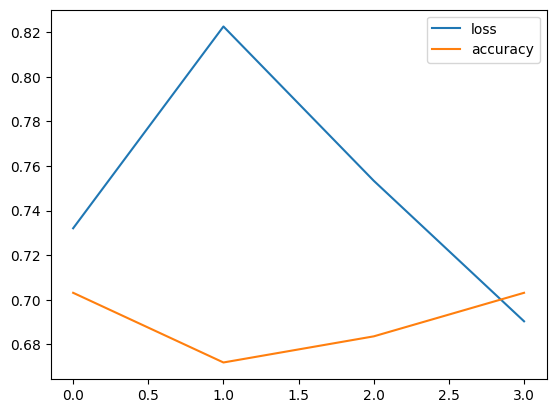

In [29]:
plt.plot(h['loss'], label = 'loss')
plt.plot(h['accuracy'], label = 'accuracy')
# plt.plot(h['val_loss'], label = 'val_loss')
# plt.plot(h['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [30]:
from keras.models import load_model

model = load_model('/content/bestmodel.h5')

In [32]:
acc = model.evaluate_generator(test_data)[1]
print("Accuracy of the model is :", acc*100)

Accuracy of the model is : 69.94660496711731


In [33]:
from tensorflow.keras.utils import load_img, img_to_array

1/1 [==============================] - 0s 239ms/step
[1]


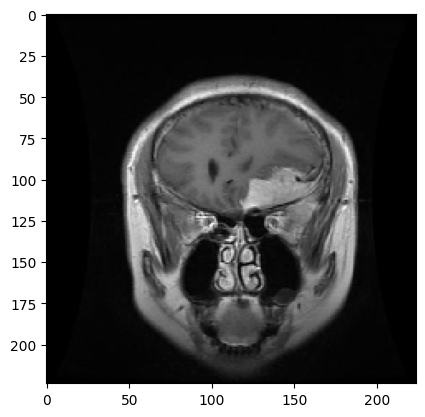

In [34]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training/meningioma/Tr-meTr_0000.jpg"
image = load_img(path, target_size = (224, 224))
input_arr = img_to_array(image)/225
plt.imshow(input_arr)
input_arr.shape
input_arr = np.expand_dims(input_arr, axis = 0)
pred = model.predict(input_arr)
classes_x=np.argmax(pred,axis=1)
print(classes_x)

In [ ]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [35]:
import numpy
import matplotlib
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input

In [37]:
def preprocessingImageTrain(path):
  """
  input : path
  output : pre processed images
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, preprocessing_function=preprocess_input, horizontal_flip = True)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32)

  return image

In [36]:
def preprocessingImageTestandValidateAndTest(path):
  """
  input : path
  output : pre processed images
  """
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory = path, target_size = (224, 224), batch_size = 32)

  return image

In [38]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training"
train_data = preprocessingImageTrain(path)

Found 5712 images belonging to 4 classes.


In [39]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Testing"
test_data = preprocessingImageTestandValidateAndTest(path)

Found 1311 images belonging to 4 classes.


In [40]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Validation"
val_data = preprocessingImageTestandValidateAndTest(path)

Found 655 images belonging to 4 classes.


In [42]:
base_model = MobileNet(input_shape = (224, 224, 3), include_top = False)

In [43]:
for layer in base_model.layers:
  layer.trainable = False

In [44]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [46]:
X = Flatten()(base_model.output)
X = Dense(units=4, activation = 'softmax')(X)

model = Model(base_model.input, X)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [49]:
model.compile(optimizer='adam', loss = keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [56]:
# Early stopping and model checkpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping
es = EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10, verbose = 1, mode = 'auto')

# model checkpoint
mc = ModelCheckpoint(filepath = "Transfermodel.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True)
cb = [es, mc]

In [57]:
hist = model.fit_generator(train_data,
                           steps_per_epoch = 10,
                           epochs = 30,
                           validation_data = val_data,
                           validation_steps = 16,
                           callbacks = cb)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.9563
Epoch 1: val_accuracy improved from -inf to 0.96484, saving model to Transfermodel.h5
10/10 [==============================] - 8s 797ms/step - loss: 0.5456 - accuracy: 0.9563 - val_loss: 0.3102 - val_accuracy: 0.9648
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9594
Epoch 2: val_accuracy did not improve from 0.96484
10/10 [==============================] - 9s 915ms/step - loss: 0.1945 - accuracy: 0.9594 - val_loss: 0.6488 - val_accuracy: 0.9453
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.9594
Epoch 3: val_accuracy did not improve from 0.96484
10/10 [==============================] - 7s 767ms/step - loss: 0.4456 - accuracy: 0.9594 - val_loss: 0.4454 - val_accuracy: 0.9609
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.9719
Epoch 4: val_accuracy did not improve from 

In [58]:
from keras.models import load_model
model = load_model('/content/Transfermodel.h5')

In [59]:
acc = model.evaluate_generator(test_data)[1]
print("Accuracy of the model is :", acc*100)

Accuracy of the model is : 95.49961686134338


1/1 [==============================] - 0s 49ms/step
[1]


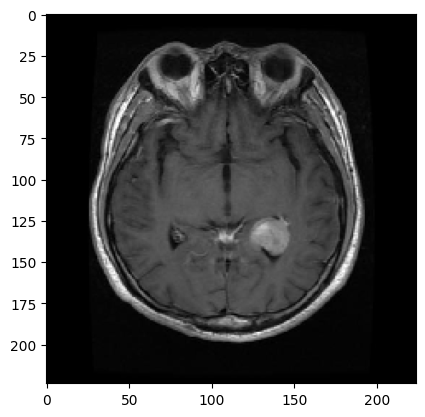

In [63]:
path = "/content/drive/MyDrive/Brain_tumor_Detection_Project/Training/meningioma/Tr-meTr_0001.jpg"
image = load_img(path, target_size = (224, 224))
input_arr = img_to_array(image)/225
plt.imshow(input_arr)
input_arr.shape
input_arr = np.expand_dims(input_arr, axis = 0)
pred = model.predict(input_arr)
classes_x=np.argmax(pred,axis=1)
print(classes_x)

In [64]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [66]:
# load best fit model
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

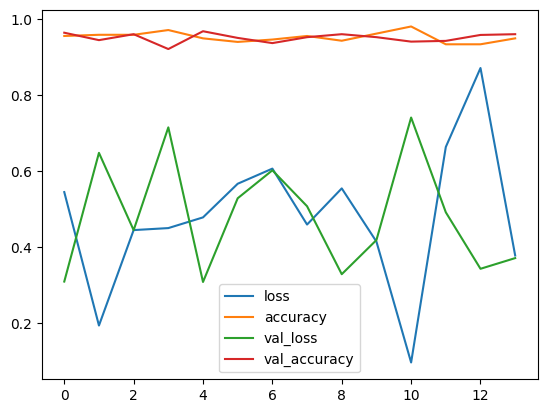

In [67]:
plt.plot(h['loss'], label = 'loss')
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_loss'], label = 'val_loss')
plt.plot(h['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()